In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [2]:
df = pd.read_csv("../data/preprocessed/final_dataset.csv")

C:\Users\benja\AppData\Local\Temp\ipykernel_31676\1439854724.py:1: DtypeWarning: Columns (20,52,54,60,61,91,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/preprocessed/final_dataset.csv")


In [3]:
df = df.loc[:, df.isna().mean()<=0.9]

In [139]:
#print('\n'.join(df.columns[60:130]))

## Group and rename variables

In [6]:
observations = {"ACRES": "acres", "NEW_ACRES": "diff_acres", "INCIDENT_AREA": "area", "prev_area_diff": "prev_diff_area" , "NUM_EVACUATED": "evacuations", "INJURIES": "injuries"}
metadata = {"report_id": "report_id", "fire_id": "fire_id", "REPORT_DOY": "doy", "date": "date", "prev_date": "last_report_date", "INCIDENT_ID": "id"}
df = df.rename(columns=metadata)

## Feature Engineering

we will create feature at the level of a report. 

This might be inconsistent: for example, cause of fire could be updated through time.

### Fire behavior
Take the set of behaviors and apply a multi-one-hot encoding. 
Order and repition is lost.

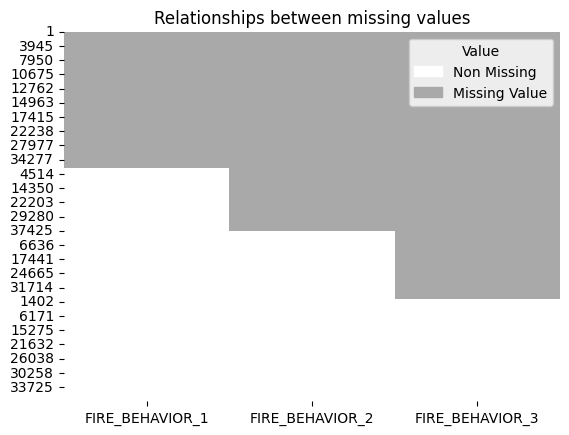

In [8]:

data = df[['FIRE_BEHAVIOR_1', 'FIRE_BEHAVIOR_2', 'FIRE_BEHAVIOR_3']].isna().astype(int).sort_values(by=['FIRE_BEHAVIOR_1', 'FIRE_BEHAVIOR_2', 'FIRE_BEHAVIOR_3'], ascending=False)
cmap = {0: 'white', 1: 'darkgrey'}
labels = ['Non Missing', 'Missing Value']
data_mapped = data.replace(cmap)
sn.heatmap(data, cmap=list(cmap.values()), cbar=False)
handles = [plt.Rectangle((0,0), 1, 1, color=cmap[label]) for label in cmap]
plt.legend(handles, labels, title='Value')
plt.title("Relationships between missing values")
plt.show()


In [9]:
## 'FIRE_BEHAVIOR_2', 'FIRE_BEHAVIOR_3'...
df['combined_fire_behavior'] = df[['FIRE_BEHAVIOR_1']].astype(str).values.tolist()
mlb = MultiLabelBinarizer()

binary_matrix = mlb.fit_transform(df['combined_fire_behavior'])
class_names = [f"behavior-{col}" for col in mlb.classes_]
binary_df = pd.DataFrame(binary_matrix, columns=class_names).drop(columns='behavior-nan')
with_behavior_df = pd.concat([df.loc[:, metadata.values()], binary_df], axis=1)

### Cause

In [10]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
cause_matrix = enc.fit_transform(df[['CAUSE']].values)
class_names = [f"cause-{cause}" for cause in enc.categories_[0]]
cause_df = pd.DataFrame(cause_matrix[:,:-1], columns=class_names[:-1])
with_cause_df = pd.concat([with_behavior_df, cause_df.astype(int)], axis=1)


c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Fuel model

In [11]:
# , 'SECNDRY_FUEL_MODEL','ADDNTL_FUEL_MODEL'
enc = OneHotEncoder(sparse=False)
mlb = MultiLabelBinarizer()
fuel_matrix = mlb.fit_transform(df[['FUEL_MODEL']].astype(str).values.tolist())
renamed_columns = [f"fuel-{col}" for col in mlb.classes_]
fuel_df = pd.DataFrame(fuel_matrix, columns=renamed_columns).drop(columns="fuel-nan")
with_fuel_df = pd.concat([with_cause_df, fuel_df.astype(int)], axis=1)


In [12]:
categories_sorted = df['GEN_FIRE_BEHAVIOR'].value_counts().index
categories_sorted

Index(['Minimal', 'Active', 'Moderate', 'Extreme'], dtype='object', name='GEN_FIRE_BEHAVIOR')

In [13]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
gen_matrix = enc.fit_transform(df[['GEN_FIRE_BEHAVIOR']].values)
renamed_columns = [f"firebhvr-{col}" for col in enc.categories_[0][:-1]]
gen_df = pd.DataFrame(gen_matrix[:, :-1], columns=renamed_columns)
with_gen_df = pd.concat([with_fuel_df, gen_df.astype(int)], axis=1)


c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
with_gacc_priority = pd.concat([with_gen_df, df['GACC_PRIORITY']], axis=1).rename(columns={'GACC_PRIORITY': 'gacc_priority'})

In [15]:
percent_strats_cols = ['PERCENT_C', 'PERCENT_FS', 'PERCENT_M', 'PERCENT_PZP']
with_method_df = pd.concat([with_gacc_priority, df[percent_strats_cols], pd.get_dummies(df['SUPPRESSION_METHOD'], prefix="method").astype(int)], axis=1)

Other features:
'PCT_CONTAINED_COMPLETED'
'PCT_PERIM_TO_BE_CONTAINED'
'PROJ_INCIDENT_AREA' : PROJ_INCIDENT_AREA-current are?
TRAIL_CLOSURE_FLAG: binary encoder Y-N => default for missing values?
ROAD_CLOSURE_FLAG: idem
RPT_FATALITIES
RPT_P_FATALITIES
RPT_P_INJURIES
RPT_R_FATALITIES
RPT_R_INJURIES
STR_DAMAGED
STR_DAMAGED_COMM
STR_DAMAGED_RES
STR_DESTROYED
STR_DESTROYED_COMM
STR_DESTROYED_RES
STR_THREATENED
STR_THREATENED_COMM
STR_THREATENED_RES
TOTAL_AERIAL
TOTAL_EVACUATIONS
TOTAL_PERSONNEL
TOTAL_P_FATALITIES
TOTAL_P_INJURIES
TOTAL_R_FATALITIES
TOTAL_R_INJURIES

this is a lot of features already. We might want to group them in fucntion of some characteristics? or just take the most important ones?

or can look at what each feature mean and transform them in physical instances:
e.g: fuel => energy available https://www.fs.usda.gov/rm/pubs_int/int_gtr122.pdf
behavior => speed of fire propagation?

## Targets

#### Area

In [16]:
with_outcomes_df = pd.concat([with_method_df, df[['NEW_ACRES', 'ACRES', 'prev_area_diff', 'INJURIES', 'FATALITIES', 'total_personnel', 'total_qty']]], axis=1) #.iloc[:,5:].corr()[['NEW_ACRES', 'prev_area_diff', 'INJURIES', 'FATALITIES']]

In [17]:
prepared_df = with_outcomes_df.assign(ros= lambda x: x['NEW_ACRES']/(x['ACRES']-x['NEW_ACRES'])).replace(np.inf, 0)
prepared_df[['ros', 'prev_area_diff']] = prepared_df[['ros', 'prev_area_diff']].fillna(0)
prepared_df.drop(columns=['gacc_priority']+percent_strats_cols, inplace=True)

Some reports are same day just because of 30mins of diff. Stabilize this.

In [18]:
prepared_df['date'] = pd.to_datetime(df['date'], format="ISO8601")
first_report_dates = prepared_df.groupby('id')['date'].min().rename('first_report_date')
prepared_df = prepared_df.merge(first_report_dates, on='id')
prepared_df['day_since_first_report'] = (prepared_df['date'] - prepared_df['first_report_date']).dt.days


In [19]:
prepared_df = prepared_df.drop(columns=["doy", "date", "last_report_date", 'ros', 'prev_area_diff', 'first_report_date', 'fire_id'])

In [20]:
prepared_df = prepared_df.rename(columns={"NEW_ACRES": "area_diff", "ACRES":"area", "INJURIES": "injuries", "FATALITIES": "fatalities"})

In [27]:
df['FIRE_BEHAVIOR_3'] # problem: for the first fire, only the first report has a fire behaviour => cleaning: could be possible to ffill/bfill inside fire group


0           Isolated Torching
1                         NaN
2                         NaN
3                         NaN
4        Short-range Spotting
                 ...         
37583              Smoldering
37584        Short Crown Runs
37585              Smoldering
37586              Smoldering
37587              Smoldering
Name: FIRE_BEHAVIOR_3, Length: 37588, dtype: object

## Drop fires

2800235 : 10e6 jump

In [316]:
prepared_df

,report_id,id,behavior-Backing,behavior-Creeping,behavior-Crowning,behavior-Flanking,behavior-Group Torching,behavior-Isolated Torching,behavior-Long-range Spotting,behavior-Running,...,method_M,method_MMS,method_PZP,area_diff,area,injuries,fatalities,total_personnel,total_qty,day_since_first_report
0,2714023,2015_2714022_BAYLE MOUNTAIN,0,1,0,0,0,0,0,0,...,0,0,0,150.0,150.0,1,0,45,5,0
1,2714037,2015_2714022_BAYLE MOUNTAIN,0,0,0,0,0,0,0,0,...,0,0,0,125.0,275.0,0,0,45,5,1
2,2714050,2015_2714022_BAYLE MOUNTAIN,0,0,0,0,0,0,0,0,...,0,0,0,0.0,275.0,1,0,33,0,2
3,2714066,2015_2714022_BAYLE MOUNTAIN,0,0,0,0,0,0,0,0,...,0,0,0,0.0,275.0,0,0,0,0,4
4,2714082,2015_2714081_BOOT COVE FIRE,0,0,0,0,0,0,0,1,...,0,0,0,205.0,205.0,0,0,21,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37583,9276418,2018_9276339_STRAWBERRY RIVER,0,0,0,0,0,0,0,0,...,0,0,0,100.0,100.0,0,0,134,14,0
37584,9276340,2018_9276339_STRAWBERRY RIVER,0,0,0,0,0,0,0,0,...,0,0,0,0.0,100.0,0,0,134,14,1
37585,9276364,2018_9276339_STRAWBERRY RIVER,0,0,0,0,0,0,0,0,...,0,0,0,0.0,100.0,0,0,109,11,1
37586,9276401,2018_9276339_STRAWBERRY RIVER,0,0,0,0,0,0,0,0,...,0,0,0,0.0,100.0,0,0,109,10,2


In [317]:
# nb = 3
# fire = prepared_df[prepared_df['ros']==prepared_df.ros.sort_values().values[-nb]]['fire_id'].iloc[0]
# prepared_df[prepared_df['fire_id']==fire]

In [326]:
prepared_df.corr()['area_diff']

ValueError: could not convert string to float: '2015_2714022_BAYLE MOUNTAIN'

## SIMPLEST DF

In [319]:
df[df.fire_id.isin(df.fire_id.unique()[:7000])]

,Colonne1,ACRES,ADDNTL_FUEL_MODEL,ANTICIPATED_COMPLETION_DATE,AREA_CLOSURE_FLAG,CAUSE,COMPLEX,COMPLEXITY_LEVEL_NARR,CRIT_RES_NEEDS_NARR,CURRENT_THREAT_NARR,...,next_derivate,will_grow,time_to_first_report,total_personnel,total_qty,day,combined_fire_behavior,first_report_date_x,day_since_first_report,first_report_date_y
0,120861,150.0,NaN,5/11/2015 12:00,N,U,False,NaN,0,0|05/07: communication sites,...,78.431373,True,0.000000,45,5,6,[Creeping],2015-05-06 10:15:00,0,2015-05-06 10:15:00
1,120862,275.0,NaN,5/8/2015 12:00,N,U,False,NaN,0,0|05/07: communication sites,...,0.000000,False,1.593750,45,5,8,[nan],2015-05-06 10:15:00,1,2015-05-06 10:15:00
2,120863,275.0,NaN,5/8/2015 12:00,N,U,False,NaN,0,0|05/07: communication sites,...,0.000000,False,2.593750,33,0,9,[nan],2015-05-06 10:15:00,2,2015-05-06 10:15:00
3,120864,275.0,NaN,5/8/2015 12:00,N,U,False,NaN,0,0|05/07: communication sites,...,NaN,False,4.114583,0,0,10,[nan],2015-05-06 10:15:00,4,2015-05-06 10:15:00
4,120865,205.0,NaN,5/10/2015 12:00,N,H,False,NaN,2-t2 eng 1-t2 helo|1-t2ia crew 2 tracked veh...,risk to utility lines|high growth potential up...,...,0.000000,False,0.000000,21,5,7,[Running],2015-05-07 07:15:00,0,2015-05-07 07:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37583,165041,100.0,Brush (2 feet),6/30/2018 12:00,N,H,False,NaN,maintain resources on scene or enr.,the sw side is the critical area with steep sl...,...,-103.064935,False,0.000000,134,14,10,[Short Crown Runs],2018-06-10 06:45:00,0,2018-06-10 06:45:00
37584,165042,100.0,Brush (2 feet),6/30/2018 12:00,N,H,False,NaN,maintain resources on scene.,the sw side is the critical area with steep sl...,...,0.000000,False,1.203125,134,14,11,[Single Tree Torching],2018-06-10 06:45:00,1,2018-06-10 06:45:00
37585,165043,100.0,Brush (2 feet),6/30/2018 12:00,N,H,False,NaN,limited fire growth potential 98% containment...,the sw side is the critical area with steep sl...,...,0.000000,False,1.947917,109,11,12,[Smoldering],2018-06-10 06:45:00,1,2018-06-10 06:45:00
37586,165044,100.0,Brush (2 feet),6/30/2018 12:00,N,H,False,NaN,limited fire growth potential 98% containment...,the sw side is the critical area with steep sl...,...,0.000000,False,2.864583,109,10,13,[Smoldering],2018-06-10 06:45:00,2,2018-06-10 06:45:00


In [320]:
request = pd.read_csv("../data/preprocessed/request_data.csv").rename(columns={"Unnamed: 0": "export_index"})
dataset = request.merge(prepared_df, left_on="fire_id", right_on="id", how="left").drop(columns=['fire_id', 'start_date', 'end_date', 'poo_lat', 'poo_lon'])

In [325]:
dataset.to_csv("../data/preprocessed/operational_table.csv")

## Split train test

In [324]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(dataset, groups=dataset['id'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds]
test = dataset.iloc[test_inds]

In [173]:
prepared_df[prepared_df['fire_id']==2800235]

,report_id,fire_id,behavior-Backing,behavior-Creeping,behavior-Crowning,behavior-Flanking,behavior-Group Torching,behavior-Isolated Torching,behavior-Long-range Spotting,behavior-Running,...,PZP,NEW_ACRES,ACRES,prev_area_diff,INJURIES,FATALITIES,total_personnel,total_qty,ros,day_since_first_report
3003,2800236,2800235,0,1,0,0,0,0,0,0,...,False,0.1,0.1,0.0,0,0,168,12,0.000000e+00,0
3004,2800963,2800235,0,0,0,0,0,0,0,0,...,False,0.0,0.1,0.0,0,0,151,11,0.000000e+00,1
3005,2800597,2800235,0,0,0,0,0,0,0,1,...,False,0.0,0.1,-134.0,0,0,133,10,0.000000e+00,2
3006,2800547,2800235,0,0,0,0,0,0,0,0,...,False,0.0,0.1,0.0,1,0,154,10,0.000000e+00,3
3007,2800572,2800235,0,0,0,0,0,0,0,0,...,False,0.0,0.1,-1242.0,0,0,156,11,0.000000e+00,4
3008,2800452,2800235,0,0,0,0,0,0,0,0,...,False,0.0,0.1,18548.0,0,0,172,10,0.000000e+00,5
3009,2800476,2800235,0,0,0,0,0,0,0,0,...,False,0.0,0.1,0.0,1,0,195,11,0.000000e+00,5
3010,2800499,2800235,0,0,0,0,0,0,0,0,...,False,0.0,0.1,4338.0,0,0,195,11,0.000000e+00,5
3011,2800523,2800235,0,0,0,0,0,0,0,0,...,False,0.0,0.1,0.0,0,0,190,10,0.000000e+00,6
3012,2800622,2800235,0,0,0,0,0,0,0,0,...,False,0.0,0.1,190.0,0,0,155,8,0.000000e+00,7
